In [1]:
import pandas as pd

# --- knobs you can tweak ---
release_year_min = 2023          # keep benchmarks released in this year or later
min_scores_per_model = 8         # after filtering, each model must have >= this many scores

# Filter to a particular list of benchmarks (leave lists empty to skip)
allow_benchmarks_by_name = []
#    "GPQA diamond", "Aider polyglot", "OTIS Mock AIME 2024-2025", "LiveBench", "SimpleBench",
#                         "Balrog", "WeirdML", "FrontierMath-2025-02-28-Private", "SWE-Bench verified", "Cybench",
#                         "OSWorld", "VPCT", "Terminal Bench", "GeoBench", "Lech Mazur Writing", "DeepResearch Bench"

allow_benchmarks_by_id = [
    # e.g., "mmlu_v1", "gsm8k_2023"
]

# Replace with your actual Sheet ID and Tab GID
sheet_id = '1v3Uvw6pAdj5jKNnLhhBfaGHzeBgZIRor6qF8SuUR7AM'
tab_gid = '1152942641' #main: 282408316

# Construct the CSV export URL
google_sheet_url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={tab_gid}'

try:
    df_data = pd.read_csv(google_sheet_url)

    # --- summary before filtering ---
    rows_before = len(df_data)
    models_before = df_data["model_id"].nunique() if "model_id" in df_data else None
    benches_before = df_data["benchmark_id"].nunique() if "benchmark_id" in df_data else None

    # --- required columns sanity check ---
    required_cols = ["model_id", "benchmark_id", "performance", "benchmark_release_date", "benchmark"]
    missing = [c for c in required_cols if c not in df_data.columns]
    if missing:
        raise KeyError(f"Missing required column(s): {missing}")

    # --- coerce types & parse dates ---
    df_data["performance"] = pd.to_numeric(df_data["performance"], errors="coerce")
    df_data["benchmark_release_date"] = pd.to_datetime(df_data["benchmark_release_date"], errors="coerce")

    # --- initial cleaning ---
    df_data = df_data.dropna(subset=["model_id", "benchmark_id", "performance", "benchmark_release_date"])

    # --- filter by release year ---
    df_data = df_data[df_data["benchmark_release_date"].dt.year >= release_year_min]

    # --- optional: filter to whitelist of benchmarks (by name and/or id) ---
    allowed_ids = set(str(x) for x in allow_benchmarks_by_id if str(x).strip())
    names_not_found = []

    if allow_benchmarks_by_name:
        tmp = (
            df_data[["benchmark_id", "benchmark"]]
            .dropna()
            .drop_duplicates()
        )
        name_to_ids = (
            tmp.assign(_name_norm=tmp["benchmark"].astype(str).str.strip().str.lower())
               .groupby("_name_norm")["benchmark_id"]
               .apply(lambda s: set(s.astype(str)))
               .to_dict()
        )
        for raw_name in allow_benchmarks_by_name:
            key = str(raw_name).strip().lower()
            if key in name_to_ids:
                allowed_ids |= name_to_ids[key]
            else:
                names_not_found.append(raw_name)

    if allowed_ids:
        df_data = df_data[df_data["benchmark_id"].astype(str).isin(allowed_ids)]

    # --- keep only models with at least min_scores_per_model scores after the above filters ---
    counts = df_data.groupby("model_id")["performance"].count()
    keep_models = counts[counts >= min_scores_per_model].index
    df_data = df_data[df_data["model_id"].isin(keep_models)]

    # --- summaries ---
    rows_after = len(df_data)
    models_after = df_data["model_id"].nunique()
    benches_after = df_data["benchmark_id"].nunique()

    print("Successfully loaded and filtered Google Sheet tab as CSV.")
    print(f"Rows: {rows_before} → {rows_after}")
    print(f"Models (unique): {models_before} → {models_after}")
    print(f"Benchmarks (unique): {benches_before} → {benches_after}")
    print(f"Kept benchmarks with release year ≥ {release_year_min} and models with ≥ {min_scores_per_model} scores.")
    if allow_benchmarks_by_name or allow_benchmarks_by_id:
        print(f"Whitelist active. Allowed IDs matched: {len(allowed_ids)}")
        if names_not_found:
            print("Names not found (after date filter):", ", ".join(map(str, names_not_found)))

        # Show which benchmarks survived (id + display name)
        kept = (df_data[["benchmark_id", "benchmark"]]
                .drop_duplicates()
                .sort_values(["benchmark"]))
        print("Benchmarks kept:")
        display(kept)

    display(df_data.head())

except Exception as e:
    print(f'An error occurred while reading or filtering the Google Sheet: {e}')
    print("Please ensure the sheet is shared as 'Anyone with the link can view' and that required columns exist:")
    print("Required: model_id, benchmark_id, performance, benchmark_release_date, benchmark")


Successfully loaded and filtered Google Sheet tab as CSV.
Rows: 1097 → 331
Models (unique): 139 → 29
Benchmarks (unique): 39 → 24
Kept benchmarks with release year ≥ 2023 and models with ≥ 8 scores.


,benchmark_id,model_id,benchmark_release_date,benchmark,model,performance
82,b1,m62,2023-11-20,GPQA diamond,gpt-5-2025-08-07,0.816
83,b17,m62,2025-06-13,DeepResearch Bench,gpt-5-2025-08-07,0.560
84,b19,m62,2025-02-21,Fiction.LiveBench,gpt-5-2025-08-07,0.972
85,b2,m62,2025-02-28,FrontierMath-2025-02-28-Private,gpt-5-2025-08-07,0.266
86,b20,m62,2025-03-01,GeoBench,gpt-5-2025-08-07,0.810


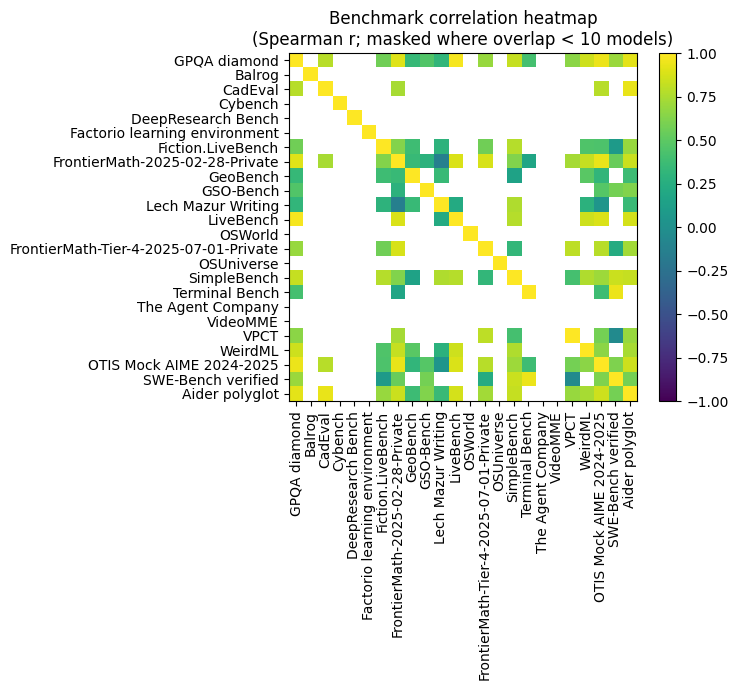

,bench_i,bench_j,r,n
10,GPQA diamond,LiveBench,0.971429,15.0
18,GPQA diamond,OTIS Mock AIME 2024-2025,0.942290,27.0
164,Terminal Bench,SWE-Bench verified,0.939394,10.0
96,FrontierMath-2025-02-28-Private,OTIS Mock AIME 2024-2025,0.934593,23.0
43,CadEval,Aider polyglot,0.930095,10.0
20,GPQA diamond,Aider polyglot,0.919965,24.0
6,GPQA diamond,FrontierMath-2025-02-28-Private,0.899219,24.0
137,LiveBench,OTIS Mock AIME 2024-2025,0.888889,14.0
89,FrontierMath-2025-02-28-Private,LiveBench,0.888473,10.0
91,FrontierMath-2025-02-28-Private,FrontierMath-Tier-4-2025-07-01-Private,0.876739,15.0


In [2]:
# === Starter analysis: steps 1–4 (de-duped top_pairs) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA

# -------- Step 1: model×benchmark matrix --------
M = df_data.pivot_table(index="model_id", columns="benchmark_id", values="performance")
bench_names = dict(df_data.groupby("benchmark_id")["benchmark"].agg(lambda s: s.dropna().iloc[0] if len(s.dropna()) else str(s.name)))

# Helper: correlations + pairwise sample sizes (ensure integer counts)
def corr_and_n(M, method="spearman", min_models=4):
    R = M.corr(method=method, min_periods=min_models)
    mask = M.notna().to_numpy(dtype=np.int32)
    N = mask.T @ mask
    N = pd.DataFrame(N, index=M.columns, columns=M.columns)
    np.fill_diagonal(N.values, M.shape[0])
    return R, N

# -------- Step 2: correlations + masked heatmap --------
R_spear, N_pairs = corr_and_n(M, method="spearman", min_models=4)

# Choose an overlap threshold that keeps enough pairs visible
DEFAULT_MIN_N = 20
upper_tri_bool = np.triu(np.ones_like(N_pairs.values, dtype=bool), 1)
n_pairs_vec = N_pairs.values[upper_tri_bool].astype(float)

if (n_pairs_vec >= DEFAULT_MIN_N).mean() < 0.33:
    adaptive = int(max(10, np.percentile(n_pairs_vec, 67)))
    MIN_N = adaptive
else:
    MIN_N = DEFAULT_MIN_N

def plot_corr_heatmap(R, N, title, min_n):
    Rm = R.where(N >= min_n)  # drop entries with too little overlap
    A = np.ma.masked_invalid(Rm.values)
    fig = plt.figure(figsize=(8.5, 7))
    im = plt.imshow(A, vmin=-1, vmax=1, interpolation="nearest")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    labels = [bench_names.get(b, str(b)) for b in R.columns]
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.yticks(range(len(labels)), labels)
    plt.title(f"{title}\n(Spearman r; masked where overlap < {min_n} models)")
    plt.tight_layout(); plt.show()

plot_corr_heatmap(R_spear, N_pairs, "Benchmark correlation heatmap", MIN_N)

# -------- de-duped strongest pairs (upper triangle only) --------
def top_pairs(R, N, k=20, min_n=MIN_N):
    r = R.copy()
    np.fill_diagonal(r.values, np.nan)

    # keep only upper triangle (i < j) to avoid symmetric duplicates
    mask_upper = pd.DataFrame(
        np.triu(np.ones(r.shape, dtype=bool), 1),
        index=r.index, columns=r.columns
    )

    s = (
        r.where(mask_upper).stack().rename("r").to_frame()
         .join(N.where(mask_upper).stack().rename("n"))
         .reset_index(names=["bench_i","bench_j"])
    )
    s = s.query("n >= @min_n").dropna(subset=["r"])
    s["abs_r"] = s["r"].abs()
    s = s.sort_values("abs_r", ascending=False).drop(columns="abs_r")

    def name(x): return bench_names.get(x, str(x))
    s["bench_i"] = s["bench_i"].map(name)
    s["bench_j"] = s["bench_j"].map(name)
    return s.head(k)

display(top_pairs(R_spear, N_pairs, k=40, min_n=MIN_N))


In [3]:
# --- Interactive scatter for two benchmarks by *display name* ---
import numpy as np, pandas as pd
from difflib import get_close_matches

# Requires plotly for hoverable interactivity:
try:
    import plotly.express as px
except ImportError as e:
    raise ImportError("Plotly is required for interactivity. Install with: pip install plotly") from e

def scatter_two_benchmarks(bench_a_name, bench_b_name, df=df_data):
    # Validate names and offer helpful suggestions
    bench_list = sorted(df["benchmark"].dropna().unique().tolist())
    missing = [b for b in (bench_a_name, bench_b_name) if b not in bench_list]
    if missing:
        msg = []
        for m in missing:
            sugg = get_close_matches(m, bench_list, n=5, cutoff=0.0)
            msg.append(f"'{m}' not found. Did you mean: {', '.join(sugg[:5]) or '(no close matches)'}")
        raise ValueError("\n".join(msg) + "\n\nUse an exact display name from:\n" + ", ".join(bench_list))

    # Keep only the two chosen benchmarks; aggregate in case of duplicates
    dat = (df.loc[df["benchmark"].isin([bench_a_name, bench_b_name]),
                  ["model_id", "model", "benchmark", "performance"]]
             .groupby(["benchmark", "model_id", "model"], as_index=False)["performance"].mean())

    A = (dat.query("benchmark == @bench_a_name")
            .rename(columns={"performance": "score_a"})
            [["model_id", "model", "score_a"]])

    B = (dat.query("benchmark == @bench_b_name")
            .rename(columns={"performance": "score_b"})
            [["model_id", "model", "score_b"]])

    both = pd.merge(A, B, on=["model_id", "model"], how="inner")
    if both.empty:
        raise ValueError(f"No models found that have results on BOTH '{bench_a_name}' and '{bench_b_name}'.")

    # Plotly interactive scatter
    fig = px.scatter(
        both,
        x="score_a", y="score_b",
        hover_name="model",
        hover_data={"model_id": True, "score_a":":.3f", "score_b":":.3f"},
        labels={"score_a": f"{bench_a_name} score", "score_b": f"{bench_b_name} score"},
        title=f"{bench_a_name} vs {bench_b_name} • models with both scores (n={len(both)})",
    )

    # Axes 0..1, 1:1 aspect, y=x reference line
    fig.update_xaxes(range=[0, 1], constrain="domain")
    fig.update_yaxes(range=[0, 1], scaleanchor="x", scaleratio=1)
    # fig.add_shape(type="line", x0=0, y0=0, x1=1, y1=1,
    #               line=dict(dash="dash", width=1), layer="below")
    fig.update_traces(marker=dict(size=8, line=dict(width=0)))

    return both, fig

# ---- Example usage: change these to your display names ----
bench_a, bench_b = "GPQA diamond", "LiveBench"
# "GPQA diamond", "LiveBench"
# "HellaSwag", "Winogrande"
# "BBH", "MMLU"
# "GPQA diamond", "ARC-AGI"
# "Terminal Bench", "SWE-Bench verified"
# "MATH level 5", "OTIS Mock AIME 2024-2025"
# "VPCT", "FrontierMath-Tier-4-2025-07-01-Private",
# "FrontierMath-2025-02-28-Private", "LiveBench"
data_points, fig = scatter_two_benchmarks(bench_a, bench_b)
fig.show()
#data_points.head()


In [4]:
# --- Find & plot outliers for correlated benchmark pairs using sigmoid-vs-sigmoid fits ---
import numpy as np, pandas as pd
from difflib import get_close_matches

# Interactive plotting
try:
    import plotly.express as px
    import plotly.graph_objects as go
except ImportError as e:
    raise ImportError("Plotly is required for interactivity. Install with: pip install plotly") from e

# ---- Build matrices & name maps (self-contained) ----
M = df_data.pivot_table(index="model_id", columns="benchmark_id", values="performance")
bench_names = dict(df_data.groupby("benchmark_id")["benchmark"].agg(lambda s: s.dropna().iloc[0] if len(s.dropna()) else str(s.name)))
model_names = dict(df_data.groupby("model_id")["model"].agg(lambda s: s.dropna().iloc[0] if len(s.dropna()) else str(s.name)))

def corr_and_n(M, method="spearman", min_models=4):
    R = M.corr(method=method, min_periods=min_models)
    mask = M.notna().to_numpy(dtype=np.int32)
    N = pd.DataFrame(mask.T @ mask, index=M.columns, columns=M.columns)
    np.fill_diagonal(N.values, M.shape[0])
    return R, N

def _sigmoid(z): return 1.0/(1.0 + np.exp(-z))
def _logit(p, eps=1e-6):
    p = np.clip(p, eps, 1-eps)
    return np.log(p/(1-p))

def _fit_sigmoid_regression(x, y):
    # Fit y_logit = a + b * x_logit
    X = _logit(x)
    Y = _logit(y)
    A = np.c_[np.ones_like(X), X]
    a, b = np.linalg.lstsq(A, Y, rcond=None)[0]
    yhat = _sigmoid(a + b*X)
    resid = y - yhat
    # scale: SD (fallback to MAD if degenerate)
    scale = float(np.std(resid, ddof=1))
    if scale < 1e-8:
        mad = float(np.median(np.abs(resid - np.median(resid))))
        scale = 1.4826 * mad if mad > 0 else 0.0
    z = resid/scale if scale > 0 else np.zeros_like(resid)
    return a, b, yhat, resid, scale, z

def _plot_pair(df_pair, a, b, bench_a_label, bench_b_label, title_suffix=""):
    # scatter with outliers highlighted; add fitted curve and y=x guide
    fig = px.scatter(
        df_pair, x="x", y="y",
        color=df_pair["is_outlier"].map({True:"Outlier", False:"Inliers"}),
        hover_name="model",
        hover_data={"model_id": True, "x":":.3f", "y":":.3f", "z":":.2f"},
        labels={"x": bench_a_label, "y": bench_b_label},
        title=f"{bench_a_label} vs {bench_b_label} {title_suffix}"
    )
    fig.update_traces(marker=dict(size=8, line=dict(width=0)))
    fig.update_xaxes(range=[0,1], constrain="domain")
    fig.update_yaxes(range=[0,1], scaleanchor="x", scaleratio=1)

    # y = x reference
    fig.add_shape(type="line", x0=0, y0=0, x1=1, y1=1, line=dict(dash="dash", width=1), layer="below")

    # fitted curve: y = sigmoid(a + b*logit(x))
    xs = np.linspace(0.001, 0.999, 400)
    ys = _sigmoid(a + b*_logit(xs))
    fig.add_trace(go.Scatter(x=xs, y=ys, mode="lines", name="Fitted curve", hoverinfo="skip"))

    return fig

def flag_outliers_all_pairs(
    corr_thresh=0.8, min_n=10, z_thresh=4.0, use_abs=True, corr_method="spearman", max_pairs=None
):
    R, N = corr_and_n(M, method=corr_method, min_models=4)

    # collect candidate pairs (upper triangle)
    pairs = []
    cols = list(R.columns)
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            r = R.iat[i, j]
            n = int(N.iat[i, j])
            if pd.isna(r) or n < min_n:
                continue
            crit = abs(r) if use_abs else r
            if crit >= corr_thresh:
                pairs.append((i, j, float(r), n))

    # sort by |r| descending
    pairs.sort(key=lambda t: -abs(t[2]))

    plots_with_hits = 0
    scanned = 0
    for (i, j, r, n) in pairs:
        if max_pairs is not None and scanned >= max_pairs:
            break
        scanned += 1

        col_i, col_j = cols[i], cols[j]
        name_i = bench_names.get(col_i, str(col_i))
        name_j = bench_names.get(col_j, str(col_j))

        sub = M[[col_i, col_j]].dropna()
        if len(sub) < min_n:
            continue

        x = sub[col_i].to_numpy()
        y = sub[col_j].to_numpy()
        model_ids = sub.index.to_numpy()
        model_disp = [model_names.get(mid, str(mid)) for mid in model_ids]

        a, b, yhat, resid, scale, z = _fit_sigmoid_regression(x, y)
        is_out = np.abs(z) > z_thresh

        if not np.any(is_out):
            continue  # only show "hits" (pairs with at least one outlier)

        df_pair = pd.DataFrame({
            "model_id": model_ids,
            "model": model_disp,
            "x": x,
            "y": y,
            "yhat": yhat,
            "resid": resid,
            "z": z,
            "is_outlier": is_out
        })

        fig = _plot_pair(
            df_pair, a, b, name_i, name_j,
            title_suffix=f"• |r|={abs(r):.3f}, n={n}, z_thresh={z_thresh}"
        )
        fig.show()

        # Print outliers in requested format: model|score1|score2
        flagged = df_pair.loc[df_pair["is_outlier"], ["model", "x", "y"]].copy()
        flagged = flagged.sort_values("model")
        print(f"Outliers for {name_i} vs {name_j}:")
        for row in flagged.itertuples(index=False):
            print(f"{row.model}|{row.x:.3f}|{row.y:.3f}")
        print()  # spacer

        plots_with_hits += 1

    print(f"Done. Pairs scanned: {scanned}. Pairs with outliers: {plots_with_hits}.")

# ---- Example usage (tweak thresholds as needed) ----
flag_outliers_all_pairs(corr_thresh=0.8, min_n=10, z_thresh=3.0, use_abs=True, corr_method="spearman")


/Users/hansgundlach/Documents/AllOtherResearch/NeelMaterial/othello/lib/python3.9/site-packages/plotly/express/_core.py:1985: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



Outliers for GPQA diamond vs OTIS Mock AIME 2024-2025:
gemini-2.0-flash-thinking-exp-01-21|0.428|0.578



/Users/hansgundlach/Documents/AllOtherResearch/NeelMaterial/othello/lib/python3.9/site-packages/plotly/express/_core.py:1985: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



Outliers for FrontierMath-2025-02-28-Private vs FrontierMath-Tier-4-2025-07-01-Private:
gpt-5-2025-08-07|0.266|0.125

Done. Pairs scanned: 20. Pairs with outliers: 2.


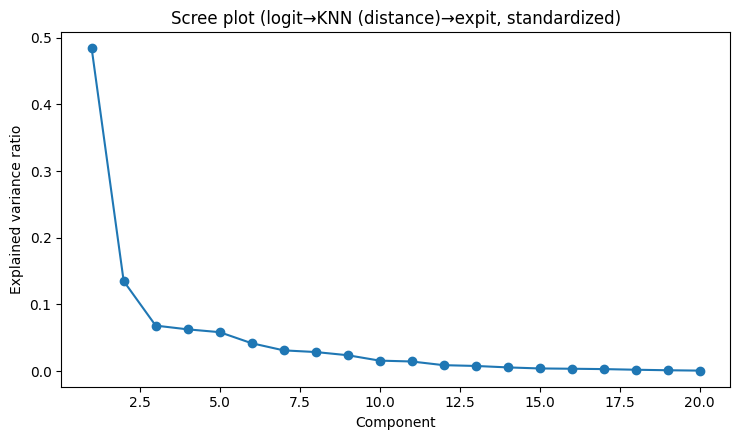

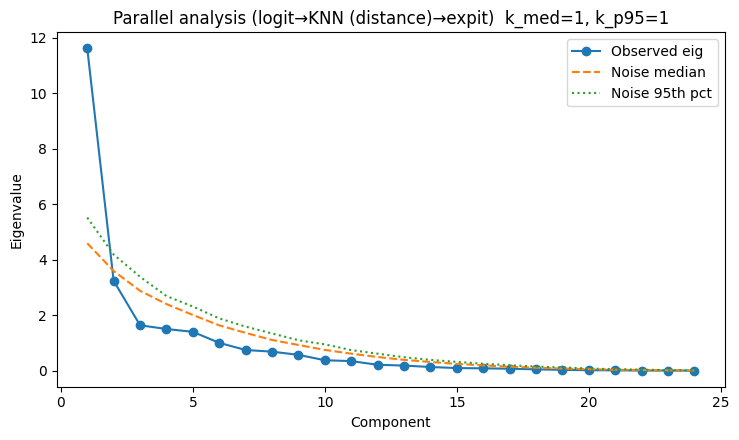

Parallel analysis suggests ~1 (vs median) or ~1 (vs 95th pct) dimensions.


,component,eigenvalue,explained_var_ratio,noise_median,noise_p95
0,1,11.618447,0.484102,4.593260,5.519941
1,2,3.239663,0.134986,3.594259,4.186911
2,3,1.636671,0.068195,2.879748,3.385897
3,4,1.501376,0.062557,2.401695,2.690505
4,5,1.400145,0.058339,2.007512,2.312625
5,6,1.002168,0.041757,1.633730,1.885547
6,7,0.744779,0.031032,1.361927,1.587234
7,8,0.684600,0.028525,1.105885,1.341721
8,9,0.570048,0.023752,0.925914,1.096631
9,10,0.375196,0.015633,0.747907,0.947439


In [5]:
# === Step 3 (variant): PCA + Parallel Analysis with logit-space, distance-weighted KNN imputation ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA

# --- knobs you can tweak ---
KNN_K = 5        # number of neighbors for KNN imputation
EPS   = 1e-6     # clipping for logit/expit to avoid +/-inf
B     = 200      # parallel analysis replicates

# --- helper transforms ---
def expit(z):  # sigmoid
    return 1.0 / (1.0 + np.exp(-z))

def logit(p, eps=EPS):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))

# --- data matrix (models × benchmarks) ---
M = df_data.pivot_table(index="model_id", columns="benchmark_id", values="performance")

# --- logit-space, distance-weighted KNN impute ---
X = M.values.astype(float)
mask_missing = np.isnan(X)

X_logit = logit(X)          # NaNs remain NaN through clip/log
imputer = KNNImputer(n_neighbors=KNN_K, weights="distance")
X_logit_imp = imputer.fit_transform(X_logit)   # fit on logit space
X_imp = expit(X_logit_imp)                     # back to [0,1]

# --- standardize columns (benchmarks) before PCA ---
col_mean = X_imp.mean(axis=0)
col_std  = X_imp.std(axis=0, ddof=1)
col_std[col_std == 0] = 1.0
Xz = (X_imp - col_mean) / col_std

# --- PCA on standardized matrix ---
pca = PCA().fit(Xz)
eig = pca.explained_variance_
evr = pca.explained_variance_ratio_
kmax = min(len(eig), 20)

# Scree plot (EVR)
plt.figure(figsize=(7.5, 4.5))
plt.plot(np.arange(1, kmax+1), evr[:kmax], marker="o")
plt.xlabel("Component")
plt.ylabel("Explained variance ratio")
plt.title("Scree plot (logit→KNN (distance)→expit, standardized)")
plt.tight_layout()
plt.show()

# --- Parallel analysis with the SAME pipeline (logit→KNN (distance)→expit) ---
rng = np.random.default_rng(0)
mask_obs = ~np.isnan(M.values)
p = M.shape[1]
noise_eigs = np.zeros((B, p))

for b in range(B):
    # independent noise per cell, then map to (0,1) so logit is well-defined
    Z = rng.standard_normal(M.shape)    # i.i.d. N(0,1)
    U = expit(Z)                        # in (0,1)
    U[~mask_obs] = np.nan               # impose the same missingness pattern

    U_logit = logit(U)                  # NaNs preserved
    U_logit_imp = imputer.fit_transform(U_logit)  # distance-weighted KNN in logit space
    U_imp = expit(U_logit_imp)

    cm = U_imp.mean(axis=0)
    cs = U_imp.std(axis=0, ddof=1); cs[cs == 0] = 1.0
    Uz = (U_imp - cm) / cs

    noise_eigs[b] = PCA().fit(Uz).explained_variance_

noise_med = np.median(noise_eigs, axis=0)
noise_p95 = np.percentile(noise_eigs, 95, axis=0)

k_med = int((eig > noise_med).sum())
k_p95 = int((eig > noise_p95).sum())

# Plot observed eigenvalues vs noise thresholds
plt.figure(figsize=(7.5, 4.5))
plt.plot(np.arange(1, len(eig)+1), eig, marker="o", label="Observed eig")
plt.plot(np.arange(1, len(eig)+1), noise_med, linestyle="--", label="Noise median")
plt.plot(np.arange(1, len(eig)+1), noise_p95, linestyle=":", label="Noise 95th pct")
plt.xlabel("Component")
plt.ylabel("Eigenvalue")
plt.title(f"Parallel analysis (logit→KNN (distance)→expit)  k_med={k_med}, k_p95={k_p95}")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Parallel analysis suggests ~{k_med} (vs median) or ~{k_p95} (vs 95th pct) dimensions.")

# --- Optional: summary table for quick inspection ---
summary = pd.DataFrame({
    "component": np.arange(1, len(eig)+1),
    "eigenvalue": eig,
    "explained_var_ratio": evr,
    "noise_median": noise_med,
    "noise_p95": noise_p95
})
summary.head(50)


In [6]:
# === Table of PC1/PC2 projections onto benchmark basis (+ loadings) ===
import numpy as np, pandas as pd
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer

# --- helpers (match prior Step 3 variant) ---
KNN_K = 10
EPS = 1e-6
def expit(z): return 1.0/(1.0 + np.exp(-z))
def logit(p, eps=EPS):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p/(1 - p))

# --- build name map for nicer labels ---
bench_names = dict(
    df_data.groupby("benchmark_id")["benchmark"]
    .agg(lambda s: s.dropna().iloc[0] if len(s.dropna()) else str(s.name))
)

# --- reuse existing PCA/M if available; otherwise reconstruct with logit→KNN(distance)→expit ---
need_refit = False
try:
    _ = pca.components_
    _ = M.columns
    need_refit = (pca.n_features_ != len(M.columns))
except Exception:
    need_refit = True

if need_refit:
    # models × benchmarks
    M = df_data.pivot_table(index="model_id", columns="benchmark_id", values="performance")
    X = M.values.astype(float)
    X_logit = logit(X)
    imputer = KNNImputer(n_neighbors=KNN_K, weights="distance")
    X_logit_imp = imputer.fit_transform(X_logit)
    X_imp = expit(X_logit_imp)
    # standardize columns
    cm = X_imp.mean(axis=0)
    cs = X_imp.std(axis=0, ddof=1); cs[cs == 0] = 1.0
    Xz = (X_imp - cm)/cs
    pca = PCA().fit(Xz)

# --- build coefficients (eigenvectors) and loadings (coeff * sqrt(eig)) ---
if pca.components_.shape[0] < 2:
    raise ValueError(f"PCA has only {pca.components_.shape[0]} component(s); need at least 2.")

coeff = pca.components_[:2].T                              # shape: [features, 2]
load  = coeff * np.sqrt(pca.explained_variance_[:2])       # correlations if inputs are standardized

tbl = pd.DataFrame(
    coeff,
    index=M.columns,
    columns=["PC1_coef", "PC2_coef"]
).assign(
    PC1_loading = load[:,0],
    PC2_loading = load[:,1],
    benchmark   = [bench_names.get(c, str(c)) for c in M.columns]
)

# Put pretty name first, keep stable id as well
tbl = tbl.reset_index().rename(columns={"index": "benchmark_id"})
tbl = tbl[["benchmark", "benchmark_id", "PC1_coef", "PC2_coef", "PC1_loading", "PC2_loading"]]

# Show the full table (unsorted), plus handy sorted snapshots:
display(tbl)

print("\nTop |coeff| contributors to PC1:")
display(tbl.reindex(tbl["PC1_coef"].abs().sort_values(ascending=False).index).head(40))

print("\nTop |coeff| contributors to PC2:")
display(tbl.reindex(tbl["PC2_coef"].abs().sort_values(ascending=False).index).head(40))


,benchmark,benchmark_id,PC1_coef,PC2_coef,PC1_loading,PC2_loading
0,GPQA diamond,b1,-0.286705,0.025084,-0.939554,0.045741
1,Balrog,b11,-0.262485,0.068762,-0.860184,0.125389
2,CadEval,b14,-0.236279,0.037765,-0.774304,0.068865
3,Cybench,b16,-0.173288,0.143337,-0.567878,0.261379
4,DeepResearch Bench,b17,-0.028420,-0.005287,-0.093133,-0.009642
5,Factorio learning environment,b18,-0.116368,0.311826,-0.381345,0.568623
6,Fiction.LiveBench,b19,-0.200853,-0.206239,-0.658210,-0.376082
7,FrontierMath-2025-02-28-Private,b2,-0.252889,-0.173908,-0.828736,-0.317126
8,GeoBench,b20,-0.084043,-0.089993,-0.275417,-0.164105
9,GSO-Bench,b22,-0.207400,0.137116,-0.679666,0.250035



Top |coeff| contributors to PC1:


,benchmark,benchmark_id,PC1_coef,PC2_coef,PC1_loading,PC2_loading
0,GPQA diamond,b1,-0.286705,0.025084,-0.939554,0.045741
23,Aider polyglot,b7,-0.282720,0.070978,-0.926495,0.129431
12,OSWorld,b29,-0.278770,-0.105026,-0.913553,-0.191517
21,OTIS Mock AIME 2024-2025,b5,-0.278025,-0.077610,-0.911111,-0.141524
15,SimpleBench,b33,-0.267779,0.045748,-0.877532,0.083423
11,LiveBench,b26,-0.262507,0.087752,-0.860256,0.160017
1,Balrog,b11,-0.262485,0.068762,-0.860184,0.125389
7,FrontierMath-2025-02-28-Private,b2,-0.252889,-0.173908,-0.828736,-0.317126
20,WeirdML,b40,-0.250486,0.126380,-0.820863,0.230457
2,CadEval,b14,-0.236279,0.037765,-0.774304,0.068865



Top |coeff| contributors to PC2:


,benchmark,benchmark_id,PC1_coef,PC2_coef,PC1_loading,PC2_loading
17,The Agent Company,b36,-0.024270,0.485278,-0.079535,0.884919
14,OSUniverse,b30,0.025340,0.434803,0.083041,0.792875
18,VideoMME,b38,0.013646,-0.393708,0.044719,-0.717937
5,Factorio learning environment,b18,-0.116368,0.311826,-0.381345,0.568623
19,VPCT,b39,-0.190294,-0.262495,-0.623607,-0.478667
13,FrontierMath-Tier-4-2025-07-01-Private,b3,-0.201248,-0.225987,-0.659507,-0.412094
6,Fiction.LiveBench,b19,-0.200853,-0.206239,-0.658210,-0.376082
7,FrontierMath-2025-02-28-Private,b2,-0.252889,-0.173908,-0.828736,-0.317126
3,Cybench,b16,-0.173288,0.143337,-0.567878,0.261379
10,Lech Mazur Writing,b25,-0.066162,0.138955,-0.216818,0.253389


In [7]:
# === Interactive scatter: models in PC1–PC2 space (color by company, custom palette) ===
import numpy as np, pandas as pd
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer

# Plotly for interactivity
try:
    import plotly.express as px
    import plotly.graph_objects as go
except ImportError as e:
    raise ImportError("Plotly is required. Install with: pip install plotly") from e

# --- knobs (match prior Step 3 variant) ---
KNN_K = 10
EPS = 1e-6
def expit(z): return 1.0/(1.0 + np.exp(-z))
def logit(p, eps=EPS):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p/(1 - p))

# --- data matrix & name map ---
M = df_data.pivot_table(index="model_id", columns="benchmark_id", values="performance")
model_names = dict(
    df_data.groupby("model_id")["model"].agg(lambda s: s.dropna().iloc[0] if len(s.dropna()) else str(s.name))
)

# --- reuse existing PCA/Xz if possible; otherwise refit with logit→KNN(distance)→expit ---
need_refit = False
try:
    _ = pca.components_
    _ = Xz.shape
    need_refit = (pca.n_features_ != Xz.shape[1])  # mismatch ⇒ refit
except Exception:
    need_refit = True

if need_refit:
    X = M.values.astype(float)
    X_logit = logit(X)
    imputer = KNNImputer(n_neighbors=KNN_K, weights="distance")
    X_logit_imp = imputer.fit_transform(X_logit)
    X_imp = expit(X_logit_imp)
    cm = X_imp.mean(axis=0)
    cs = X_imp.std(axis=0, ddof=1); cs[cs == 0] = 1.0
    Xz = (X_imp - cm) / cs
    pca = PCA().fit(Xz)

# --- get PC scores for each model ---
scores = pca.transform(Xz)[:, :2]  # PC1, PC2
evr = pca.explained_variance_ratio_
df_scores = pd.DataFrame(scores, index=M.index, columns=["PC1", "PC2"]).reset_index()
df_scores["model"] = df_scores["model_id"].map(model_names.get)
df_scores["n_benchmarks"] = M.notna().sum(axis=1).reindex(df_scores["model_id"]).to_numpy()

# --- parse company from model name (case-insensitive; first rule wins) ---
rules = [
    ("Anthropic", lambda s: "claude" in s),
    ("OpenAI",    lambda s: ("o1-" in s) or ("o3-" in s) or ("o4-" in s) or ("gpt" in s)),
    ("Google",    lambda s: "gemini" in s),
    ("xAI",       lambda s: "grok" in s),
    ("DeepSeek",  lambda s: "seek" in s),
    ("Moonshot",  lambda s: "kimi" in s),
]
def infer_company(name):
    s = (name or "").strip().lower()
    for label, pred in rules:
        if pred(s):
            return label
    return "Other"

df_scores["company"] = df_scores["model"].apply(infer_company)

# --- custom colors ---
color_map = {
    "Anthropic": "purple",
    "Google": "teal",
    "OpenAI": "magenta",
    "xAI": "blue",
    "DeepSeek": "gold",
    "Moonshot": "red",
    "Other": "lightgray",
}

# --- interactive scatter ---
fig = px.scatter(
    df_scores,
    x="PC1", y="PC2",
    color="company",
    color_discrete_map=color_map,
    category_orders={"company": ["Anthropic","OpenAI","Google","xAI","DeepSeek","Moonshot","Other"]},
    hover_name="model",
    hover_data={"model_id": True, "PC1":":.3f", "PC2":":.3f", "n_benchmarks": True, "company": True},
    title="Models in principal component space (PC1 vs PC2)"
)
fig.update_traces(marker=dict(size=8, line=dict(width=0)))
fig.update_layout(
    xaxis_title=f"PC1 ({evr[0]*100:.1f}% var)",
    yaxis_title=f"PC2 ({evr[1]*100:.1f}% var)",
    legend_title_text="Company"
)
# zero lines for reference
fig.add_hline(y=0, line=dict(dash="dash", width=1), layer="below")
fig.add_vline(x=0, line=dict(dash="dash", width=1), layer="below")

fig.show()

# Optional: peek at the table
df_scores.head(50)


/Users/hansgundlach/Documents/AllOtherResearch/NeelMaterial/othello/lib/python3.9/site-packages/plotly/express/_core.py:1985: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



,model_id,PC1,PC2,model,n_benchmarks,company
0,m10,1.411277,5.684545,claude-3-5-sonnet-20241022,18,Anthropic
1,m102,-2.126855,0.177122,o1-2024-12-17,12,OpenAI
2,m103,2.581333,-0.876910,o1-mini-2024-09-12,8,OpenAI
3,m105,-4.447685,-0.320717,o3-2025-04-16,17,OpenAI
4,m106,-1.323904,-0.870600,o3-mini-2025-01-31,14,OpenAI
5,m107,-3.451521,-1.566448,o4-mini-2025-04-16,15,OpenAI
6,m11,-1.564030,2.745108,claude-3-7-sonnet-20250219,18,Anthropic
7,m15,-3.061234,-0.515979,claude-opus-4-1-20250805,9,Anthropic
8,m16,-1.553193,1.700122,claude-opus-4-20250514,10,Anthropic
9,m17,-0.743634,2.026710,claude-sonnet-4-20250514,12,Anthropic
